In [32]:
import batchflow as bf
from batchflow import Dataset, V, F, B, action, Batch
from batchflow.models.torch.layers import ConvBlock
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Lets generate some linear data

In [3]:
def data_generator(size, dim):
    step = 5 / size
    x = np.array([np.arange(0, 5, step) for i in range(dim)]).T
    coef = np.random.randint(-3, 3, size=dim)
    y = x @ coef + np.random.uniform(-0.5, 0.5, size=size)
    return x, y

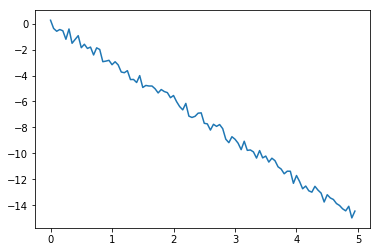

In [13]:
size, dim = 100, 1
x, y = data_generator(100, 1) # generation of 100 points
plt.plot(x, y)

### Define MyBatch class

In [4]:
class MyBatch(Batch):
    components = 'features', 'targets'

In [14]:
dataset = Dataset(index=size, batch_class=MyBatch)
dataset.split()

### Define MyModel class to specify our nn with 1 hidden layer without activation

In [ ]:
class MyModel(TorchModel):
    @classmethod
    def default_config(cls):
        config = TorchModel.default_config()
        config['body'].update(dict(layout='df', units=1))
        return config
    
    def build_config(self, names=None):
        config = super().build_config(names)
        return config
     
    @classmethod
    def body(cls, **kwargs):
        kwargs = cls.get_defaults('body', kwargs)
        x = ConvBlock(**kwargs)
        return x

### Lets define  loss and optimizer. NN architechture already specified in MyModel class

In [16]:
config =  {
    'loss' : 'mse',
    'optimizer': {'name': 'SGD',
                 'lr': 0.1},
    'inputs': dict(features={'shape': dim},
                   targets={'shape' : 1}),
    'initial_block/inputs': 'features',
}

In [29]:
batch_size = 1

In [34]:
pipeline = (dataset.train.p
            .load(src=(x, y))
             #.init_variable('loss')
            .init_model('dynamic', MyModel, 'linear', config=config)
            .train_model('linear', feed_dict=dict(features=B('features'), 
                                                  targets=B('targets')))
            .run(batch_size, shuffle=True, n_epochs=1))

ConvBlock: dropout_rate is zero or undefined, so dropout layer is skipped


TypeError: train() got an unexpected keyword argument 'feed_dict'

### Another way to specify MyModel class pushing the single neuron of out net to HEAD instead of BODY block

In [26]:
class MyModel_1(TorchModel):
    @classmethod
    def default_config(cls):
        config = TorchModel.default_config()
        config['head'].update(dict(layout='df', units=1))
        return config
    
    def build_config(self, names=None):
        config = super().build_config(names)
        config['head/units'] = self.num_classes('targets')
        return config
     
    @classmethod
    def head(cls, **kwargs):
        kwargs = cls.get_defaults('head', kwargs)
        x = ConvBlock(**kwargs)
        return x